<a href="https://colab.research.google.com/github/sindhu-web15/kpop-stack/blob/main/my_Ai_Ck_%26_Jaffe_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


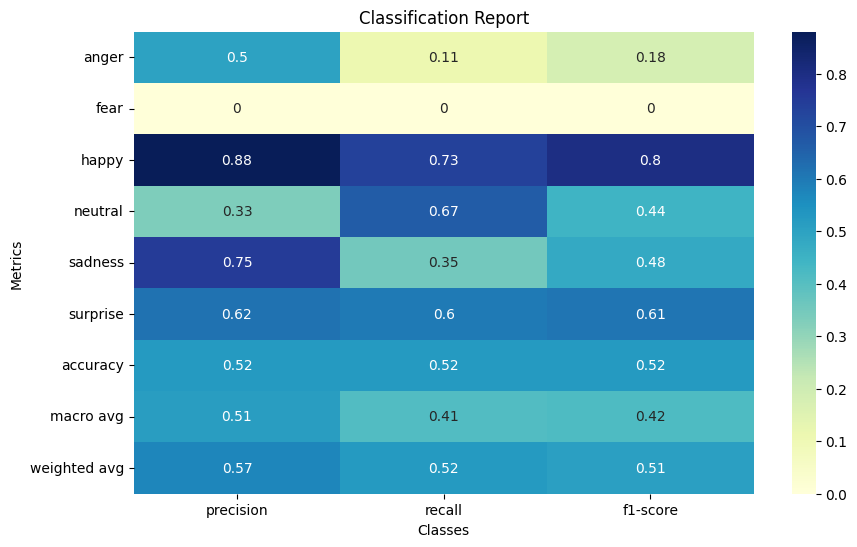

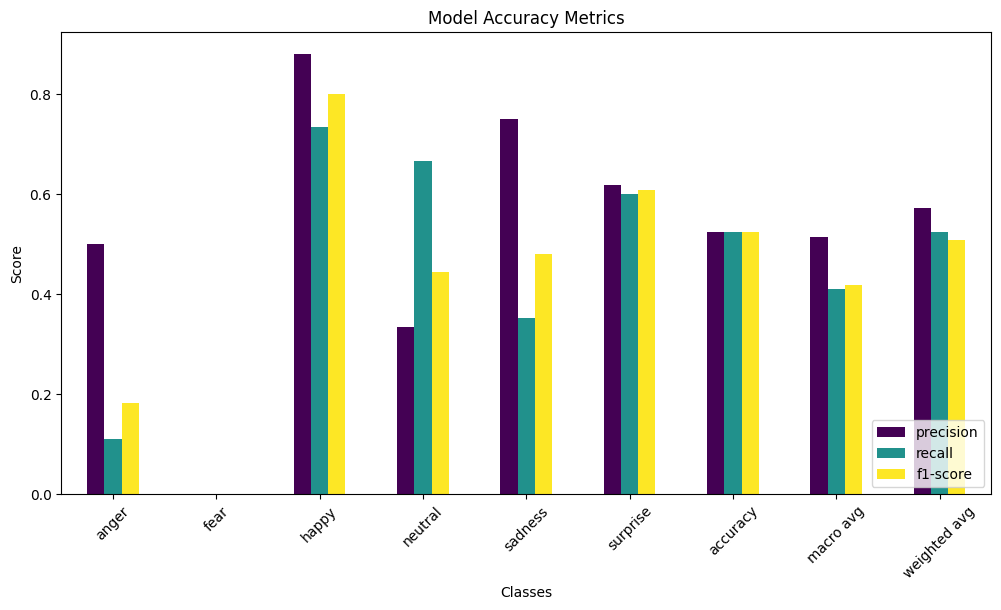

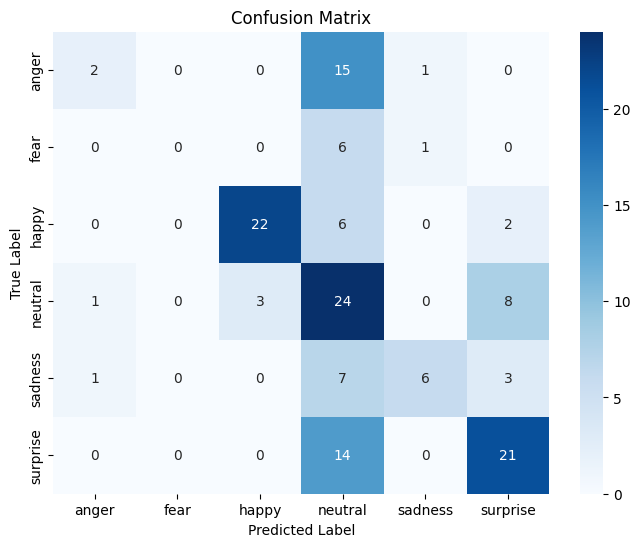

Random Forest model saved to /content/drive/My Drive/random_forest_facial_emotion_model.pkl
SVM model for LBP features saved to /content/drive/My Drive/svm_facial_emotion_model.pkl


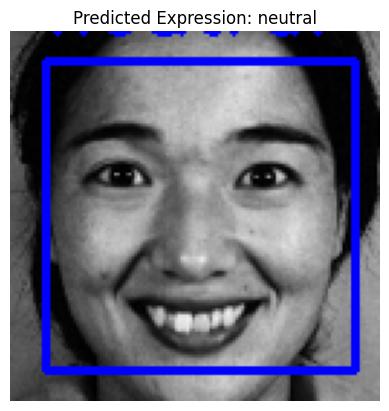

In [13]:
# Import necessary libraries
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern

from google.colab import drive
drive.mount('/content/drive')

# Paths to datasets
train_folder_path = '/content/drive/My Drive/CK_dataset/CK_dataset/train'
test_folder_path = '/content/drive/My Drive/CK_dataset/CK_dataset/test'
haarcascade_path = '/content/drive/My Drive/haarcascade_frontalface_default.xml'

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Function to load and preprocess images for PCA
def load_and_preprocess_images(folder_path):
    data = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]  # Crop face region
                        face_resized = cv2.resize(face_region, (64, 64))  # Resize for consistency
                        data.append(face_resized.flatten())  # Flatten the image
                        labels.append(label)
    return np.array(data), np.array(labels)

# Function to load and preprocess images for LBP
def extract_lbp_features(folder_path):
    data = []
    labels = []
    radius = 1
    n_points = 8 * radius
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]  # Crop face region
                        face_resized = cv2.resize(face_region, (64, 64))  # Resize for consistency
                        lbp = local_binary_pattern(face_resized, n_points, radius, method="uniform")
                        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
                        hist = hist.astype("float")
                        hist /= (hist.sum() + 1e-6)  # Normalize
                        data.append(hist)
                        labels.append(label)
    return np.array(data), np.array(labels)

# Load and preprocess datasets for PCA-based Random Forest
X_train, y_train = load_and_preprocess_images(train_folder_path)
X_test, y_test = load_and_preprocess_images(test_folder_path)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=150)  # Reduce to 150 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test_pca)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Plot classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Plot accuracy metrics (precision, recall, F1-score) as bar charts
metrics_df = pd.DataFrame(report).iloc[:-1, :].T[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Model Accuracy Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the Random Forest model for later use
import joblib
rf_model_path = '/content/drive/My Drive/random_forest_facial_emotion_model.pkl'
joblib.dump(rf_classifier, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# Train an SVM Classifier on LBP Features
X_train_lbp, y_train_lbp = extract_lbp_features(train_folder_path)
X_test_lbp, y_test_lbp = extract_lbp_features(test_folder_path)

svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train_lbp, y_train_lbp)

# Save the SVM model for LBP features
svm_model_path = '/content/drive/My Drive/svm_facial_emotion_model.pkl'
joblib.dump(svm_classifier, svm_model_path)
print(f"SVM model for LBP features saved to {svm_model_path}")

# Function to predict and display the expression of a single image using LBP features
def predict_emotion(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    for (x, y, w, h) in faces:
        face_region = gray_img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, (64, 64))
        lbp = local_binary_pattern(face_resized, 8 * 1, 1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 * 1 + 3), range=(0, 8 * 1 + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)

        features = hist.reshape(1, -1)
        predicted_expression = model.predict(features)[0]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, predicted_expression, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis('off')
    plt.show()

# Example usage for single image using SVM
image_path = "/content/drive/My Drive/testimages/testimages/27.tiff"
predict_emotion(image_path, svm_classifier)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


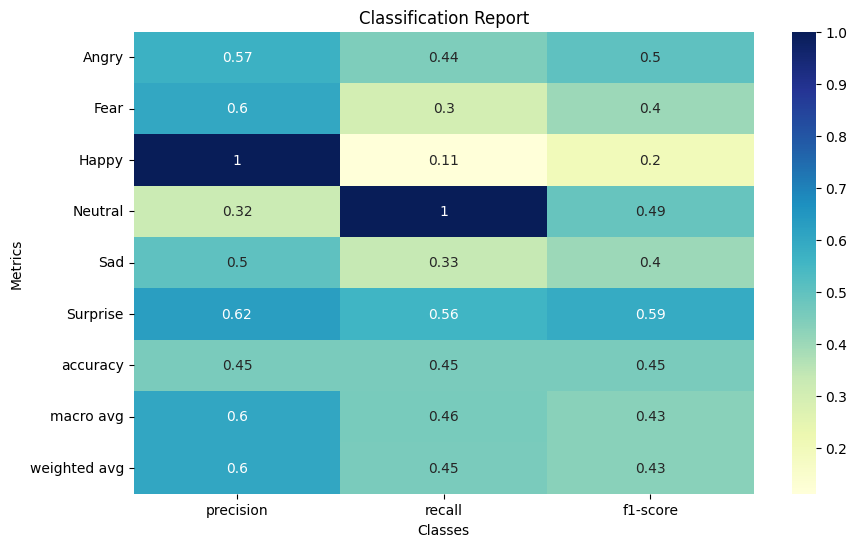

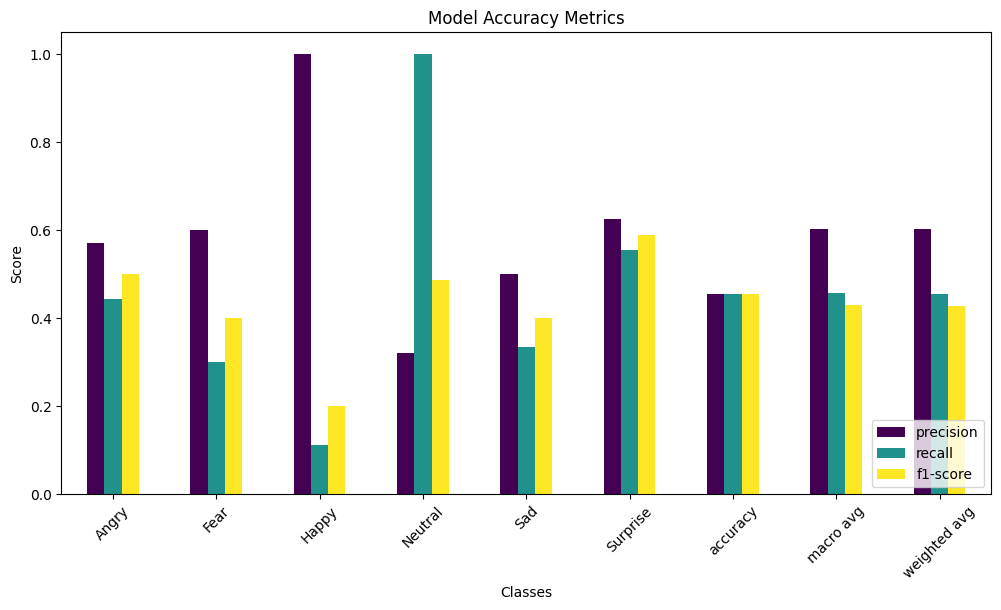

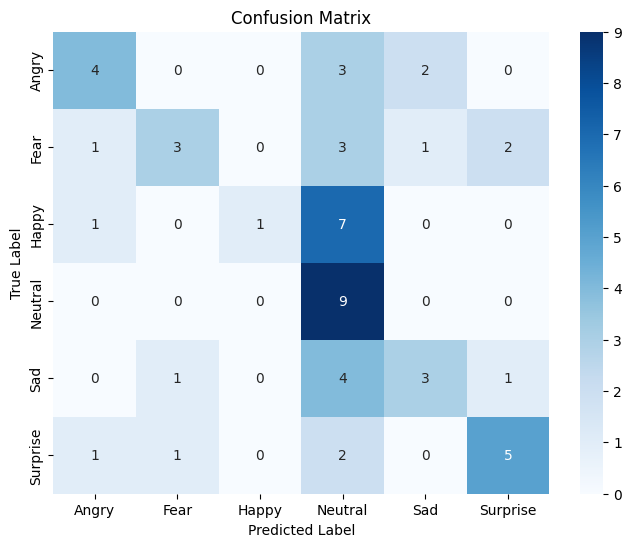

Random Forest model saved to /content/drive/My Drive/random_forest_facial_emotion_model.pkl
SVM model for LBP features saved to /content/drive/My Drive/svm_facial_emotion_model.pkl


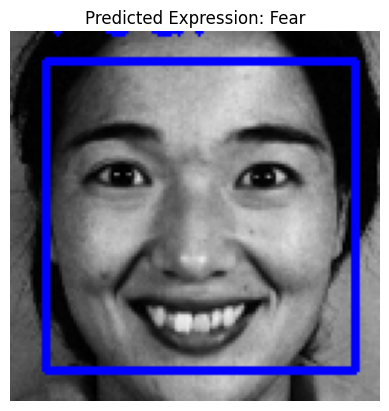

In [14]:
# Import necessary libraries
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern

from google.colab import drive
drive.mount('/content/drive')

# Paths to datasets
train_folder_path = '/content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]/train'
test_folder_path = '/content/drive/MyDrive/JAFFE-[70,30]/JAFFE-[70,30]/test'
haarcascade_path = '/content/drive/My Drive/haarcascade_frontalface_default.xml'

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Function to load and preprocess images for PCA
def load_and_preprocess_images(folder_path):
    data = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]  # Crop face region
                        face_resized = cv2.resize(face_region, (64, 64))  # Resize for consistency
                        data.append(face_resized.flatten())  # Flatten the image
                        labels.append(label)
    return np.array(data), np.array(labels)

# Function to load and preprocess images for LBP
def extract_lbp_features(folder_path):
    data = []
    labels = []
    radius = 1
    n_points = 8 * radius
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]  # Crop face region
                        face_resized = cv2.resize(face_region, (64, 64))  # Resize for consistency
                        lbp = local_binary_pattern(face_resized, n_points, radius, method="uniform")
                        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
                        hist = hist.astype("float")
                        hist /= (hist.sum() + 1e-6)  # Normalize
                        data.append(hist)
                        labels.append(label)
    return np.array(data), np.array(labels)

# Load and preprocess datasets for PCA-based Random Forest
X_train, y_train = load_and_preprocess_images(train_folder_path)
X_test, y_test = load_and_preprocess_images(test_folder_path)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=128)  # Reduce to 150 principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = rf_classifier.predict(X_test_pca)

# Generate a classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Plot classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()

# Plot accuracy metrics (precision, recall, F1-score) as bar charts
metrics_df = pd.DataFrame(report).iloc[:-1, :].T[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Model Accuracy Metrics')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save the Random Forest model for later use
import joblib
rf_model_path = '/content/drive/My Drive/random_forest_facial_emotion_model.pkl'
joblib.dump(rf_classifier, rf_model_path)
print(f"Random Forest model saved to {rf_model_path}")

# Train an SVM Classifier on LBP Features
X_train_lbp, y_train_lbp = extract_lbp_features(train_folder_path)
X_test_lbp, y_test_lbp = extract_lbp_features(test_folder_path)

svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train_lbp, y_train_lbp)

# Save the SVM model for LBP features
svm_model_path = '/content/drive/My Drive/svm_facial_emotion_model.pkl'
joblib.dump(svm_classifier, svm_model_path)
print(f"SVM model for LBP features saved to {svm_model_path}")

# Function to predict and display the expression of a single image using LBP features
def predict_emotion(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    for (x, y, w, h) in faces:
        face_region = gray_img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_region, (64, 64))
        lbp = local_binary_pattern(face_resized, 8 * 1, 1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 * 1 + 3), range=(0, 8 * 1 + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)

        features = hist.reshape(1, -1)
        predicted_expression = model.predict(features)[0]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, predicted_expression, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis('off')
    plt.show()

# Example usage for single image using SVM
image_path = "/content/drive/My Drive/testimages/testimages/27.tiff"
predict_emotion(image_path, svm_classifier)
